<a href="https://colab.research.google.com/github/amotu/DSCI-400/blob/main/DSCI_400_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
import librosa
import librosa.display
import IPython.display as ipd
import tensorflow as tf
%tensorflow_version 2.x

In [ ]:
# PARAMETERS
BATCH_SIZE = 64
SAMPLING_RATE = 22000
NUM_MELS = 512
FMAX = 10000
TOP_DB = 30
EPS = 1e-6
SEED = 42
N_MFCC = 13

In [ ]:
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
os.chdir('/content/gdrive/MyDrive/DSCI400')

# Data Generator

In [ ]:
from utils.DataPreparation import create_mel, DataGenerator

In [ ]:
path = '/content/gdrive/MyDrive/DSCI400/Coughnet Audio'

In [ ]:
train_data = DataGenerator(SAMPLING_RATE, NUM_MELS, FMAX, TOP_DB, EPS, SEED, path, 'train')
test_data = DataGenerator(SAMPLING_RATE, NUM_MELS, FMAX, TOP_DB, EPS, SEED, path, 'test')
val_data = DataGenerator(SAMPLING_RATE, NUM_MELS, FMAX, TOP_DB, EPS, SEED, path, 'val')

In [ ]:
list(train_data.data.as_numpy_iterator()) # Used to view the contents

[(array([[ 52,  35,  10, ...,  22,   3, 136],
         [ 64,  47,  22, ...,  34,  15, 148],
         [ 49,  31,  28, ...,  26,  50, 147],
         ...,
         [  0,   0,   0, ...,   0,   0,  20],
         [  0,   0,   0, ...,   0,   0,  20],
         [  0,   0,   0, ...,   0,   0,  20]], dtype=uint8), 1),
 (array([[ 0,  0,  0, ...,  0,  0, 87],
         [ 0,  0,  0, ...,  0,  2, 99],
         [ 0,  0,  0, ...,  0,  0, 97],
         ...,
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8), 1),
 (array([[154, 135,  77, ...,   0,  17, 121],
         [167, 147,  89, ...,   0,  29, 133],
         [165, 146, 103, ...,   0,  33, 130],
         ...,
         [ 78,  59,   0, ...,   0,   0,  68],
         [ 77,  58,   0, ...,   0,   0,  68],
         [ 77,  58,   0, ...,   0,   0,  68]], dtype=uint8), 0),
 (array([[ 91,  87,  77, ...,   0,   0,  37],
         [103,  99,  89, ...,   0,   0,  49],
         [106, 11

In [ ]:
list(train_data.data.take(4).as_numpy_iterator())

# Generate Spectograms

In [ ]:
#Generate spectrograms for each audio sample with classification
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
for i, (audio, status) in enumerate(list(train_data.data.take(n).as_numpy_iterator())):
  r = i // cols
  c = i % cols
  ax = axes[r][c]

  plt.subplot(ax)
  librosa.display.specshow(audio)
  plt.colorbar()

  if status == 1:
    label = 'Positive'
  else:
    label = 'Negative'
  ax.set_title(label)

plt.show()

# Handcrafted Features Generator

In [ ]:
train_ds = train_data.data.batch(BATCH_SIZE) # Batched to be fed for the model
test_ds = test_data.data.batch(BATCH_SIZE)
val_ds = val_data.data.batch(BATCH_SIZE)

In [ ]:
from tensorflow.keras import layers, datasets, models
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow import keras
import scipy

In [ ]:
from utils.GetFeatures import feature_extraction

In [ ]:
audio_path = '/content/gdrive/MyDrive/DSCI400/Coughnet Audio'

def GenerateVectors(path, dataset_type, LARGE_STATS=True):
  positive_paths = []
  negative_paths = []
  for entry in os.scandir(os.path.join(path, os.path.join(dataset_type, 'pos'))):
    if entry.is_file():
      positive_paths.append(entry.path)
  for entry in os.scandir(os.path.join(path, os.path.join(dataset_type, 'neg'))):
    if entry.is_file():
      negative_paths.append(entry.path)
        
  path_to_audio_vec_p = list(map(lambda x: feature_extraction(x, True), positive_paths))
  pos_audio_ds = tf.data.Dataset.from_tensor_slices(path_to_audio_vec_p)
  pos_labels_ds = tf.data.Dataset.from_tensor_slices([1 for i in positive_paths])
  p_ds = tf.data.Dataset.zip((pos_audio_ds, pos_labels_ds))

  path_to_audio_vec_n = list(map(lambda x: feature_extraction(x, True), negative_paths))
  neg_audio_ds = tf.data.Dataset.from_tensor_slices(path_to_audio_vec_n)
  neg_labels_ds = tf.data.Dataset.from_tensor_slices([0 for i in negative_paths])
  n_ds = tf.data.Dataset.zip((neg_audio_ds, neg_labels_ds))
        
  combined_ds = p_ds.concatenate(n_ds)
  combined_ds = combined_ds.shuffle(len(combined_ds), seed=SEED)
  return combined_ds

In [ ]:
train_data_vec = GenerateVectors(audio_path, 'test')
test_data_vec = GenerateVectors(audio_path, 'train')
val_data_vec = GenerateVectors(audio_path, 'val')

In [ ]:
list(train_data_vec.as_numpy_iterator())

# Modeling

In [ ]:
for vector, _ in train_data_vec.take(1):
  input_shape_2 = vector.shape
print(input_shape_2)

(885,)


In [ ]:
for spectrogram, _ in train_ds.take(1):
  input_shape = spectrogram.shape # Get the input sizes: (64, 512, 215)
print(input_shape)

In [ ]:
input_shape = (64, 512, 215) # Not sure which one to use
input_shape2 = input_shape_2

In [ ]:
def conv_block(x, num, filters, activation='relu'):

  for i in range(num):
      x = layers.Conv2D(filters, kernel_size = 3, padding="same")(x)
      x = layers.BatchNormalization()(x)
  x = layers.Activation(activation)(x)
  
  return layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)


In [ ]:
def fully_connected_block(x, units):
  
  x = layers.Dense(units, activation="relu")(x)

  return layers.Dropout(0.25)(x)


## CNN + Sequential

In [ ]:
def build_model2(input_shape1, input_shape2, num_classes):
  
  input = layers.Input(shape=input_shape1) # idk if I should include batch_size=BATCH_SIZE as a parameters
  input2 = layers.Input(shape=input_shape2)

  x = layers.Conv2D(16, kernel_size=5, padding='same')(input) # Input block
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.MaxPool2D(pool_size=2, strides=2)(x)

  x = conv_block(x, 3, 16) # Main Convolution Blocks
  x  = conv_block(x, 2, 8)

  x = layers.Flatten()(x) # Classification Layers for Convolutional block
  x = fully_connected_block(x, 128)
  x = fully_connected_block(x, 32)

  x2 = layers.Dense(256, activation='relu')(input2) # Sequential Part
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.Dense(128, activation='relu')(x2)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.Dense(32, activation='relu')(x2)
  x2 = layers.Dropout(0.25)(x2)
  
  x = layers.Add()([x, x2]) # Merge

  outputs = keras.layers.Dense(num_classes, activation="softmax")(x) # 2 classes, COVID, No COVID
  
  return keras.models.Model(inputs=[input, input2], outputs=outputs)

In [ ]:
new_model = build_model2((64, 512, 215), input_shape_2, 2)

In [ ]:
new_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 64, 512, 215 0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 64, 512, 16)  86016       input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 64, 512, 16)  64          conv2d_31[0][0]                  
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 64, 512, 16)  0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

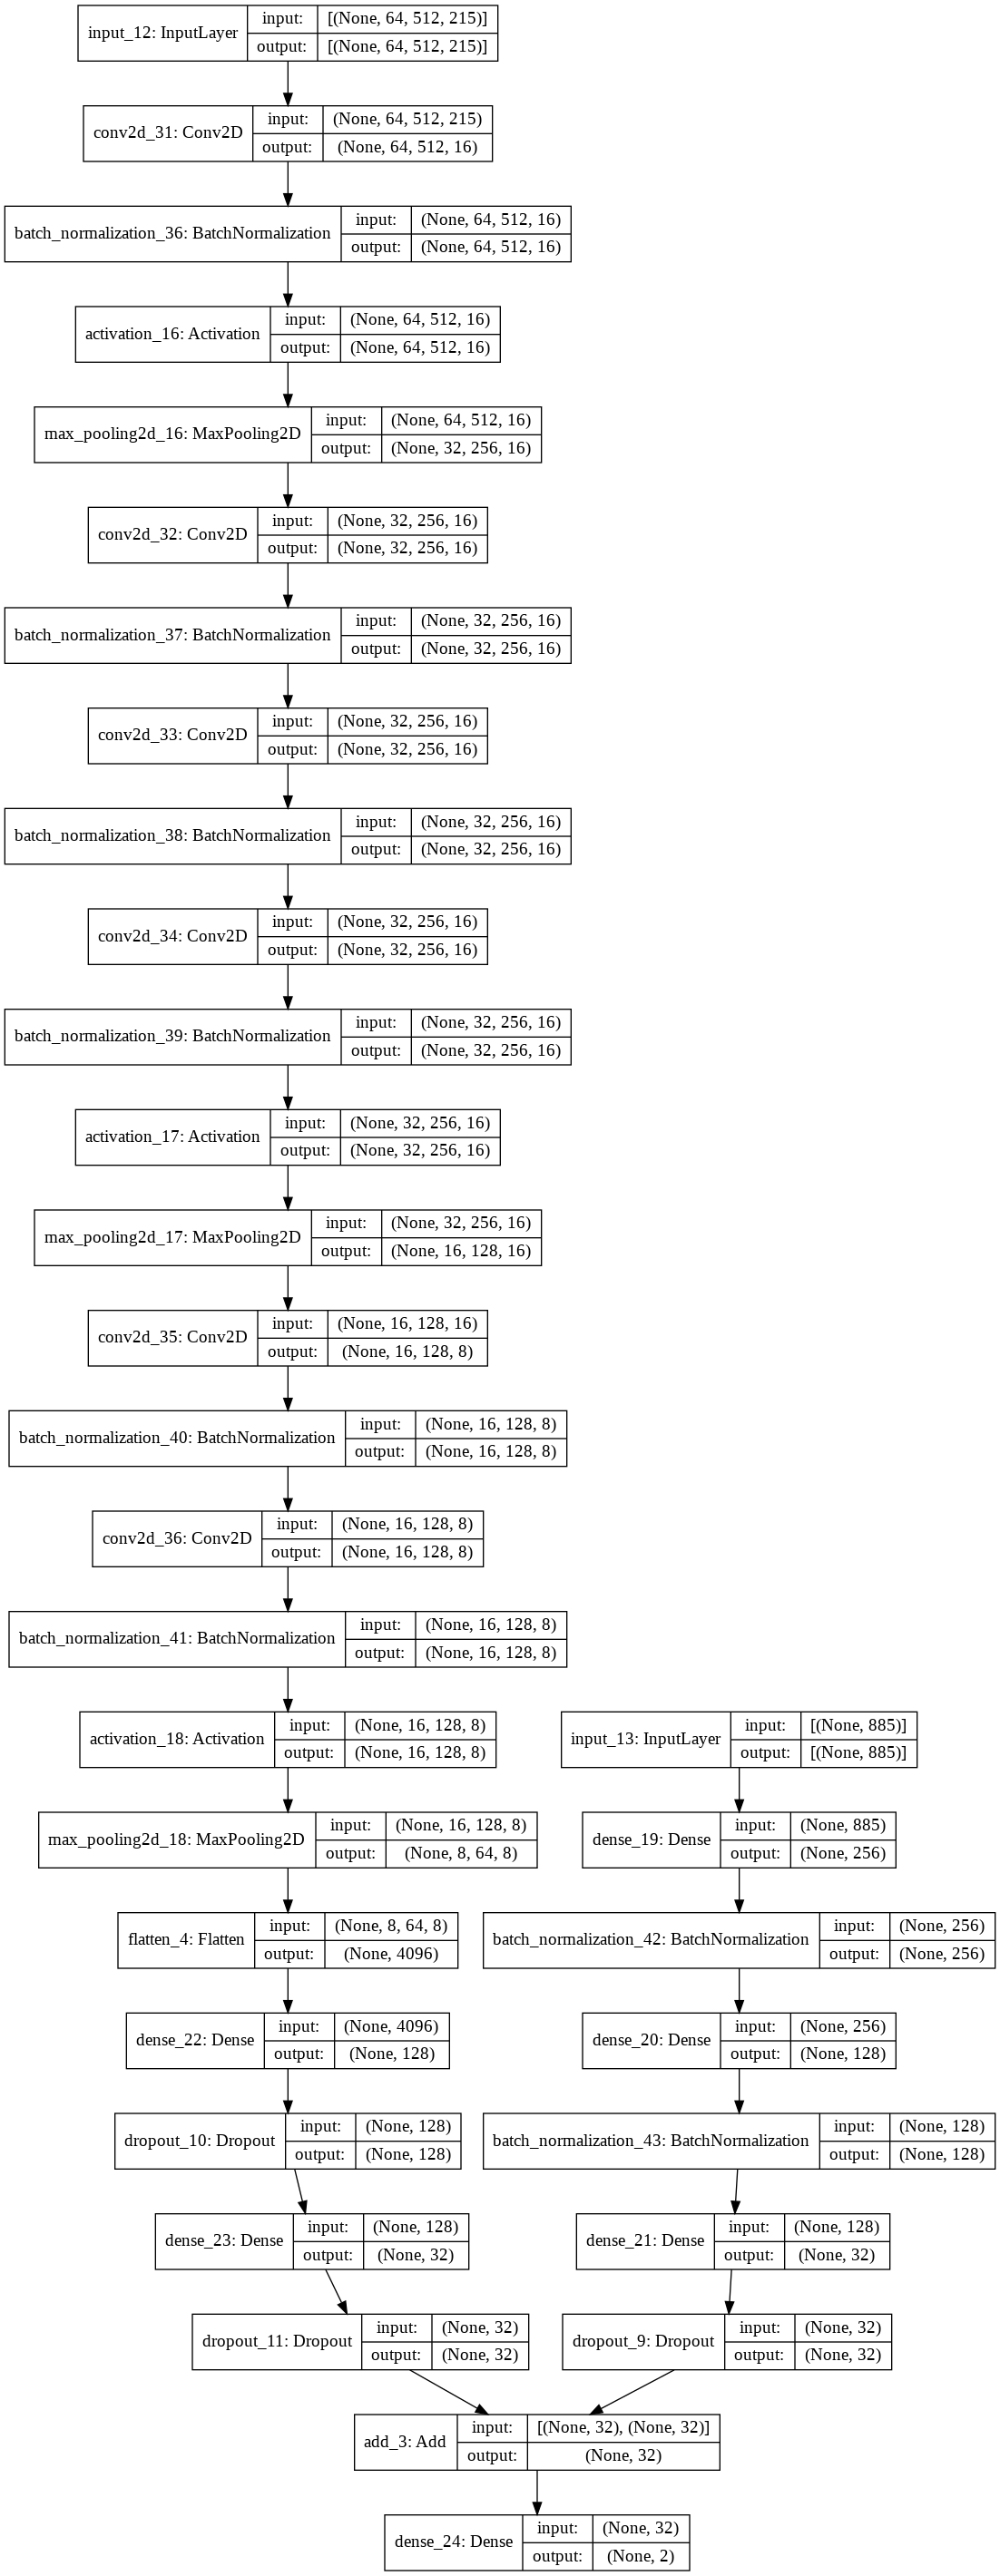

In [ ]:
keras.utils.plot_model(new_model, show_shapes=True)

## CNN

In [ ]:
input_shape = (64, 512, 215) # Not sure which one to use
#input_shape = (512, 215, 1)

def build_model(input_shape, num_classes):
  
  input = layers.Input(shape=input_shape) # idk if I should include batch_size=BATCH_SIZE as a parameters
  
  x = layers.Conv2D(16, kernel_size=5, padding='same')(input) # Input block
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.MaxPool2D(pool_size=2, strides=2)(x)

  x = conv_block(x, 3, 16)
  x  = conv_block(x, 2, 8)

  x = layers.Flatten()(x)
  x = fully_connected_block(x, 128)
  x = fully_connected_block(x, 32)

  outputs = keras.layers.Dense(num_classes, activation="softmax")(x) # 2 classes, COVID, No COVID
  
  return keras.models.Model(inputs=input, outputs=outputs)

In [ ]:
x = None

In [ ]:
a = build_model(input_shape, 2)
a.summary()

In [ ]:
keras.utils.plot_model(a, show_shapes=True)

In [ ]:
a.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy

model_save_filename = "model.h5"
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(model_save_filename, monitor="val_accuracy", save_best_only=True)

# Andrew

In [ ]:
#model = model.Sequential([ 
    # Model Here
  
  #1. Feature extraction and mapping: 2-3 pairs of convolution and pooling layer pairs: ex. do 2-3 of these

  #layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape)
  #layers.MaxPooling2D((2, 2))

  #2. NN:  
  #a. Dropout (set some random points in the feature map to 0. Increase this to help prevent over fitting if we have that issue): layers.Dropout(0.25),
  #b. Flatten (setup for NN, you gotta do this lol): layers.Flatten(),
  #c. Density connected NN layer. Use relu for your first one: layers.Dense( units , activation='relu')
  #d. Add more Density connected NN layers as you wish, ex: layers.Dense(units, activation='softmax')                     

  #])
  #3. Compile your thing: see https://www.tensorflow.org/tutorials/audio/simple_audio
  #4. Run model on Training data: 
  #model.fit(train_ds, validation_ds, epochs=10)
  #train_ds should be an array containing just the spectrograms. 
  #validation_ds should be a 1xN vector/array and each value should correspond to the status of simiarlly indexed spectrogram. EX. validation_ds = [1, 1, 0, 0] would mean the the 1st and 2nd spectrogram of train_ds are positive cases.

#Example of a two layered 

input_shape = (None, 512, 215)

model = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

#Compile:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

#Run on training data
model.fit(x=train_ds, validation_data=val_ds, epochs=10)


In [ ]:
type(train_ds.element_spec[0].shape)